# Ditto for Entity Resolution (FAIR-DA4ER)

This notebook implements the **Ditto** method for **Entity Resolution (ER)** as described in the [FAIR-DA4ER](https://github.com/MarcoNapoleone/FAIR-DA4ER) repository.

## Overview (from README)

- **FAIR-DA4ER** provides code for training **Ditto** models for Entity Resolution, with optional **FAIR-DA4ER** data augmentation.
- **Ditto** (Li et al.) casts Entity Matching as a **sequence-pair classification** problem using pre-trained LMs (e.g. BERT, DistilBERT).
- **Data format**: Each example is a line: `record1 \t record2 \t label`, where each record is serialized as `COL attr_name VAL attr_value COL ...` and label is `0` (no match) or `1` (match).
- **Task config**: Datasets are defined in `configs.json` with `trainset`, `validset`, `testset` paths.

## 1. Clone FAIR-DA4ER repo and install dependencies

All configs, data paths, and code come from the [FAIR-DA4ER](https://github.com/MarcoNapoleone/FAIR-DA4ER) repository. Run the cell below to clone the repo and install from its `requirements.txt`. Subsequent cells run from the repo root.

In [11]:
# Clone FAIR-DA4ER repo (skip if already cloned)
import os
REPO_DIR = "FAIR-DA4ER"
if not os.path.isdir(REPO_DIR):
    !git clone https://github.com/MarcoNapoleone/FAIR-DA4ER.git {REPO_DIR}
%cd {REPO_DIR}

# Install dependencies from repo's requirements.txt
!pip install -q -r requirements.txt

Cloning into 'FAIR-DA4ER'...


remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 469 (delta 232), reused 467 (delta 230), pack-reused 0 (from 0)
Receiving objects: 100% (469/469), 35.38 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (232/232), done.
Updating files: 100% (160/160), done.
/workspace/Ditto/FAIR-DA4ER


In [12]:
# Install dependencies into the same Python this kernel uses
import sys
!{sys.executable} -m pip install -q numpy torch transformers scikit-learn


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip


## 2. Imports

In [13]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.13/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [15]:
cd ditto

/workspace/Ditto/FAIR-DA4ER/ditto


## 3. Load task configuration (configs.json from repo)

In [16]:
# Load config: use IJF/sentence-bert/)._sentence-bert (data/ijf Paths relative to ditto/.
CONFIG_PATH = "configs.json"
if not os.path.isfile(CONFIG_PATH):
    CONFIG_PATH = os.path.join(os.path.dirname(os.path.abspath(".")), "configs.json")
with open(CONFIG_PATH) as f:
    configs = json.load(f)
configs_by_name = {c["name"]: c for c in configs}

TASK_NAME = "IJF_sentence-bert"
DITTO_DIR = os.path.dirname(os.path.abspath(CONFIG_PATH))

# Resolve DITTO_DIR: if data/ijf/sentence-bert/train.txt is not here, walk up until we find it (fixes nested cd)
IJF_TRAIN_REL = os.path.join("data", "ijf", "sentence-bert", "train.txt")
while DITTO_DIR != os.path.dirname(DITTO_DIR):
    if os.path.isfile(os.path.join(DITTO_DIR, IJF_TRAIN_REL)):
        break
    DITTO_DIR = os.path.dirname(DITTO_DIR)

if TASK_NAME in configs_by_name:
    config = configs_by_name[TASK_NAME]
    trainset_path = os.path.join(DITTO_DIR, config["trainset"])
    validset_path = os.path.join(DITTO_DIR, config["validset"])
    testset_path = os.path.join(DITTO_DIR, config["testset"])
else:
    trainset_path = os.path.join(DITTO_DIR, "data", "ijf", "sentence-bert", "train.txt")
    validset_path = os.path.join(DITTO_DIR, "data", "ijf", "sentence-bert", "valid.txt")
    testset_path = os.path.join(DITTO_DIR, "data", "ijf", "sentence-bert", "test.txt")
    print(f"(IJF_sentence-bert not in configs.json; using paths under {DITTO_DIR})")

print(f"Task: {TASK_NAME}")
print(f"DITTO_DIR: {DITTO_DIR}")
print(f"Train: {trainset_path}, Valid: {validset_path}, Test: {testset_path}")
print(f"Train exists: {os.path.isfile(trainset_path)}, Valid: {os.path.isfile(validset_path)}, Test: {os.path.isfile(testset_path)}")

(IJF_sentence-bert not in configs.json; using paths under /workspace/Ditto/FAIR-DA4ER/ditto)
Task: IJF_sentence-bert
DITTO_DIR: /workspace/Ditto/FAIR-DA4ER/ditto
Train: /workspace/Ditto/FAIR-DA4ER/ditto/data/ijf/sentence-bert/train.txt, Valid: /workspace/Ditto/FAIR-DA4ER/ditto/data/ijf/sentence-bert/valid.txt, Test: /workspace/Ditto/FAIR-DA4ER/ditto/data/ijf/sentence-bert/test.txt
Train exists: True, Valid: True, Test: True


## 4. Ditto dataset (Ditto serialization format)

Each line: `record1 \t record2 \t label`. Records use `COL` / `VAL` tokens.

In [10]:
cd ..

/workspace/Ditto


In [17]:
class DittoDataset(Dataset):
    """Dataset for Ditto ER: pairs of serialized records + binary label."""

    def __init__(self, path, tokenizer, max_len=256, size=None):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pairs = []
        self.labels = []

        lines = open(path).readlines() if isinstance(path, str) else path
        for line in lines:
            line = line.strip()
            if not line:
                continue
            parts = line.split("\t")
            if len(parts) != 3:
                continue
            s1, s2, label = parts[0], parts[1], int(parts[2])
            self.pairs.append((s1, s2))
            self.labels.append(label)

        if size:
            self.pairs = self.pairs[:size]
            self.labels = self.labels[:size]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        left, right = self.pairs[idx]
        # Compatible with old (encode_plus) and new (callable) transformers
        tokenizer_fn = getattr(self.tokenizer, "encode_plus", self.tokenizer)
        enc = tokenizer_fn(
            left,
            right,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

    @staticmethod
    def collate_fn(batch):
        return {
            "input_ids": torch.stack([b["input_ids"] for b in batch]),
            "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
            "labels": torch.stack([b["labels"] for b in batch]),
        }

# Model name (same as FAIR-DA4ER / megagonlabs ditto)
LM_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(LM_NAME)

MAX_LEN = 256

# CPU-friendly: randomly subsample train/valid/test to fixed sizes
N_TRAIN_IJF = 2000
N_VALID_IJF = 250
N_TEST_IJF = 250
SEED_IJF = 42

random.seed(SEED_IJF)
np.random.seed(SEED_IJF)

def load_and_sample(path, n_target):
    """Load file and randomly sample n_target lines (or all if file has fewer)."""
    with open(path) as f:
        lines = [line.strip() for line in f if line.strip()]
    if len(lines) <= n_target:
        return lines
    idx = np.random.choice(len(lines), size=n_target, replace=False)
    return [lines[i] for i in sorted(idx)]

train_lines = load_and_sample(trainset_path, N_TRAIN_IJF)
valid_lines = load_and_sample(validset_path, N_VALID_IJF)
test_lines = load_and_sample(testset_path, N_TEST_IJF)

train_ds = DittoDataset(train_lines, tokenizer, max_len=MAX_LEN)
valid_ds = DittoDataset(valid_lines, tokenizer, max_len=MAX_LEN)
test_ds = DittoDataset(test_lines, tokenizer, max_len=MAX_LEN)

print(f"Train: {len(train_ds)}, Valid: {len(valid_ds)}, Test: {len(test_ds)} (random subsample)")
print(f"Match rate (train): {100 * np.mean(train_ds.labels):.1f}%")
print("Sample:", train_ds.pairs[0], "->", train_ds.labels[0])

Train: 1998, Valid: 250, Test: 249 (random subsample)
Match rate (train): 37.8%
Sample: ('COL name VAL WORLD FUEL SERVICES COL name_clean VAL WORLD FUEL SERVICES COL sources VAL ["fd"] COL count VAL 1520 COL lobby_count VAL 0 COL amount VAL 41556465.18 COL amount_bc VAL null COL example VAL WORLD FUEL SERVICES', 'COL name VAL SERVICE FUEL SERVICE CANADA COL name_clean VAL SERVICE FUEL SERVICE CANADA COL sources VAL ["fd"] COL count VAL 1 COL lobby_count VAL 0 COL amount VAL 0 COL amount_bc VAL null COL example VAL service fuel service canada') -> 1


## 5. Ditto model (LM + linear head for binary classification)

In [18]:
class DittoModel(nn.Module):
    """Ditto: pre-trained LM with a linear layer for binary match classification."""

    def __init__(self, lm_name="distilbert-base-uncased", num_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(lm_name)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] representation
        pooled = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled)
        return logits

## 6. Training loop

In [19]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

BATCH_SIZE = 8
LR = 3e-5
N_EPOCHS = 5

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=DittoDataset.collate_fn,
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    collate_fn=DittoDataset.collate_fn,
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    collate_fn=DittoDataset.collate_fn,
)

model = DittoModel(lm_name=LM_NAME).to(device)
optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = len(train_loader) * N_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 668.87it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [20]:
def evaluate(model, loader, threshold=None):
    """Evaluate model. If threshold is None, find optimal F1 threshold; else use it."""
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]
            logits = model(input_ids, attention_mask)
            probs = logits.softmax(dim=1)[:, 1].cpu().numpy()
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)
    if threshold is not None:
        preds = [1 if p > threshold else 0 for p in all_probs]
        f1 = f1_score(all_labels, preds)
        return f1, threshold, preds, all_labels
    best_f1, best_th = 0.0, 0.5
    for th in np.arange(0.0, 1.0, 0.05):
        p = [1 if x > th else 0 for x in all_probs]
        f1 = f1_score(all_labels, p)
        if f1 > best_f1:
            best_f1, best_th = f1, th
    pred_best = [1 if x > best_th else 0 for x in all_probs]
    return best_f1, best_th, pred_best, all_labels

def train_epoch(model, loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0.0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [21]:
best_dev_f1 = 0.0
best_test_f1 = 0.0

for epoch in range(1, N_EPOCHS + 1):
    loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)
    dev_f1, dev_th, _, _ = evaluate(model, valid_loader)
    test_f1, _, _, _ = evaluate(model, test_loader, threshold=dev_th)
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        best_test_f1 = test_f1

    print(f"Epoch {epoch} | loss={loss:.4f} | dev_f1={dev_f1:.4f} | test_f1={test_f1:.4f} | best_test_f1={best_test_f1:.4f}")

Epoch 1 | loss=0.5202 | dev_f1=0.9379 | test_f1=0.9171 | best_test_f1=0.9171
Epoch 2 | loss=0.1588 | dev_f1=0.9274 | test_f1=0.9385 | best_test_f1=0.9171
Epoch 3 | loss=0.0656 | dev_f1=0.9302 | test_f1=0.9545 | best_test_f1=0.9171
Epoch 4 | loss=0.0356 | dev_f1=0.9432 | test_f1=0.9432 | best_test_f1=0.9432
Epoch 5 | loss=0.0164 | dev_f1=0.9438 | test_f1=0.9444 | best_test_f1=0.9444


## 7. Final test report (using validation threshold)

In [22]:
dev_f1, dev_th, _, _ = evaluate(model, valid_loader)
test_f1, _, test_preds, test_labels = evaluate(model, test_loader, threshold=dev_th)

print("Final test set performance (threshold from validation):")
print(classification_report(test_labels, test_preds, target_names=["No match", "Match"]))
print(f"F1: {f1_score(test_labels, test_preds):.4f}, Precision: {precision_score(test_labels, test_preds):.4f}, Recall: {recall_score(test_labels, test_preds):.4f}")

Final test set performance (threshold from validation):
              precision    recall  f1-score   support

    No match       0.96      0.97      0.97       158
       Match       0.96      0.93      0.94        91

    accuracy                           0.96       249
   macro avg       0.96      0.95      0.96       249
weighted avg       0.96      0.96      0.96       249

F1: 0.9444, Precision: 0.9551, Recall: 0.9341


In [23]:
# Inspect FP, FN, TP, TN examples on the IJF sentence-bert subset
import numpy as np

# Convert labels/predictions to numpy arrays
y_true = np.array(test_labels)
y_pred = np.array(test_preds)

# Indices for each case
tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"TP: {len(tp_idx)}, FP: {len(fp_idx)}, TN: {len(tn_idx)}, FN: {len(fn_idx)}")


def show_examples(ds, idxs, kind, k=5):
    """Pretty-print up to k examples for a given index set."""
    print(f"\n=== {kind} examples (showing up to {k}) ===")
    for idx in idxs[:k]:
        rec1, rec2 = ds.pairs[idx]
        label = ds.labels[idx]
        print(f"\nIndex: {idx}")
        print(f"True label: {label}")
        print(f"Record 1: {rec1}")
        print(f"Record 2: {rec2}")

# Show a few examples of each type from the test set
# show_examples(test_ds, tp_idx, "True Positives")
show_examples(test_ds, fp_idx, "False Positives")
# show_examples(test_ds, tn_idx, "True Negatives")
# show_examples(test_ds, fn_idx, "False Negatives")

TP: 85, FP: 4, TN: 154, FN: 6

=== False Positives examples (showing up to 5) ===

Index: 15
True label: 0
Record 1: COL name VAL ECS AUTOMATION COL name_clean VAL ECS AUTOMATION COL sources VAL ["fd"] COL count VAL 1 COL lobby_count VAL 0 COL amount VAL 0 COL amount_bc VAL null COL example VAL ECS Automation
Record 2: COL name VAL ECLYPSYS SOLUTIONS COL name_clean VAL ECLYPSYS SOLUTIONS COL sources VAL ["fd"] COL count VAL 3 COL lobby_count VAL 0 COL amount VAL 0 COL amount_bc VAL null COL example VAL Eclypsys Solutions

Index: 28
True label: 0
Record 1: COL name VAL BLUE METRIC ENVIRONMENTAL COL name_clean VAL BLUE METRIC ENVIRONMENTAL COL sources VAL ["fd"] COL count VAL 1 COL lobby_count VAL 0 COL amount VAL 144300 COL amount_bc VAL null COL example VAL Blue Metric Environmental Inc
Record 2: COL name VAL BLUEWAVE ENERGAY COL name_clean VAL BLUEWAVE ENERGAY COL sources VAL ["fd"] COL count VAL 1 COL lobby_count VAL 0 COL amount VAL 23199.58 COL amount_bc VAL null COL example VAL Bl

## 8. Predict on new pairs (optional)

Serialize two records in Ditto format (`COL attr VAL value ...`) and get match probability.

In [24]:
def predict_pair(model, tokenizer, record1, record2, max_len=256):
    """Predict match probability for a pair of Ditto-serialized records."""
    enc = tokenizer(
        record1,
        record2,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    model.eval()
    with torch.no_grad():
        logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
        prob_match = logits.softmax(dim=1)[0, 1].item()
    return prob_match

# Example
r1 = "COL title VAL samsung galaxy COL brand VAL samsung"
r2 = "COL title VAL samsung galaxy s21 COL brand VAL samsung"
prob = predict_pair(model, tokenizer, r1, r2)
print(f"Match probability: {prob:.4f} -> {'Match' if prob >= 0.5 else 'No match'}")

Match probability: 0.1112 -> No match


---
## Part B: Ditto with Data Augmentation (DA_iTunes-Amazon)

This section trains Ditto on **DA_iTunes-Amazon** using **in-training data augmentation (MixDA)** from the repo: the train set uses the `ditto_light` dataset with `da='del'` (span deletion), and the model mixes original and augmented representations during training. Valid/test use no augmentation. Results are reported as before.

In [25]:
# Ensure we're in the repo's ditto directory (paths are relative to it)
import os
try:
    _ditto_dir = os.path.join(REPO_DIR, "ditto")
except NameError:
    _ditto_dir = os.path.join("FAIR-DA4ER", "ditto")
if os.path.isdir(_ditto_dir) and not os.path.isfile("configs.json"):
    os.chdir(_ditto_dir)
# Load config for DA_iTunes-Amazon (configs[1])
with open("configs.json") as f:
    configs_da = json.load(f)
TASK_NAME_DA = configs_da[1]["name"]  # DA_iTunes-Amazon
config_da = {c["name"]: c for c in configs_da}[TASK_NAME_DA]
trainset_path_da = config_da["trainset"]
validset_path_da = config_da["validset"]
testset_path_da = config_da["testset"]
print(f"Task (with DA): {TASK_NAME_DA}")
print(f"Train: {trainset_path_da}, Valid: {validset_path_da}, Test: {testset_path_da}")

Task (with DA): DA_iTunes-Amazon
Train: data/fair/iTunes-Amazon/train.txt, Valid: data/fair/iTunes-Amazon/valid.txt, Test: data/fair/iTunes-Amazon/test.txt


In [31]:
from transformers.optimization import get_linear_schedule_with_warmup


In [32]:
# Use ditto_light dataset with in-training augmentation (da='del') for train; no DA for valid/test
import sys
_ditto_abs = os.path.abspath(_ditto_dir)
if _ditto_abs not in sys.path:
    sys.path.insert(0, _ditto_abs)
from ditto_light.dataset import DittoDataset as DittoDatasetDA
from ditto_light.ditto import DittoModel as DittoModelDA

MAX_LEN_DA = 256
DA_OP = "del"  # span deletion (or 'all' for RandAugment)
train_ds_da = DittoDatasetDA(trainset_path_da, lm="distilbert", max_len=MAX_LEN_DA, da=DA_OP)
valid_ds_da = DittoDatasetDA(validset_path_da, lm="distilbert", max_len=MAX_LEN_DA, da=None)
test_ds_da = DittoDatasetDA(testset_path_da, lm="distilbert", max_len=MAX_LEN_DA, da=None)

BATCH_SIZE_DA = 8
train_loader_da = DataLoader(train_ds_da, batch_size=BATCH_SIZE_DA, shuffle=True, collate_fn=DittoDatasetDA.pad)
valid_loader_da = DataLoader(valid_ds_da, batch_size=BATCH_SIZE_DA * 2, shuffle=False, collate_fn=DittoDatasetDA.pad)
test_loader_da = DataLoader(test_ds_da, batch_size=BATCH_SIZE_DA * 2, shuffle=False, collate_fn=DittoDatasetDA.pad)
print(f"Train: {len(train_ds_da)}, Valid: {len(valid_ds_da)}, Test: {len(test_ds_da)} (with DA op={DA_OP} on train)")

Train: 321, Valid: 109, Test: 109 (with DA op=del on train)


In [33]:
# Model with MixDA (mixes original + augmented [CLS] during training)
set_seed(42)
model_da = DittoModelDA(device=device, lm="distilbert", alpha_aug=0.8).to(device)
optimizer_da = AdamW(model_da.parameters(), lr=LR)
num_steps_da = len(train_loader_da) * N_EPOCHS
scheduler_da = get_linear_schedule_with_warmup(optimizer_da, num_warmup_steps=0, num_training_steps=num_steps_da)
criterion_da = nn.CrossEntropyLoss()

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 540.01it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [34]:
def train_epoch_da(model, loader, optimizer, scheduler, criterion):
    """Train one epoch; loader returns (x1, x2, y) when DA is used, (x, y) otherwise."""
    model.train()
    total_loss = 0.0
    for batch in loader:
        optimizer.zero_grad()
        if len(batch) == 3:
            x1, x2, y = batch
            logits = model(x1, x2)
        else:
            x, y = batch
            logits = model(x)
        loss = criterion(logits, y.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_da(model, loader, threshold=None):
    """Evaluate; valid/test loaders return (x, y) only."""
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                x, _, y = batch
            else:
                x, y = batch
            logits = model(x)
            probs = logits.softmax(dim=1)[:, 1].cpu().numpy()
            all_labels.extend(y.numpy())
            all_probs.extend(probs)
    if threshold is not None:
        preds = [1 if p > threshold else 0 for p in all_probs]
        return f1_score(all_labels, preds), threshold, preds, all_labels
    best_f1, best_th = 0.0, 0.5
    for th in np.arange(0.0, 1.0, 0.05):
        p = [1 if x > th else 0 for x in all_probs]
        f1 = f1_score(all_labels, p)
        if f1 > best_f1:
            best_f1, best_th = f1, th
    pred_best = [1 if x > best_th else 0 for x in all_probs]
    return best_f1, best_th, pred_best, all_labels

---
## IJF Blocking with Sentence-BERT (top-20 only)

Load `pro_supplier_with_clean_and_canonical_trimmed.csv`, apply sentence-BERT blocking (top-20 per record), then create train/test/valid splits and train Ditto.

In [35]:
# Step 1: Load CSV and serialize records to Ditto format
import csv
import os
import sys
import re
import numpy as np
from collections import defaultdict

# Path to the CSV
CSV_PATH_BLOCKING = "data/ijf/blocking_sentence_bert/pro_supplier_with_clean_and_canonical_trimmed.csv"

# Ensure we're in ditto directory - try multiple paths
if not os.path.isfile(CSV_PATH_BLOCKING):
    CSV_PATH_BLOCKING = os.path.join(DITTO_DIR, CSV_PATH_BLOCKING)
if not os.path.isfile(CSV_PATH_BLOCKING):
    # Try relative to current working directory
    CSV_PATH_BLOCKING = os.path.join("FAIR-DA4ER", "ditto", CSV_PATH_BLOCKING)

# Load CSV and serialize to Ditto format
records_blocking = []
canonical_ints = []
with open(CSV_PATH_BLOCKING, encoding="utf-8", newline="") as f:
    reader = csv.DictReader(f)
    columns = [c for c in reader.fieldnames if c != "canonical_int"]  # exclude canonical_int from record text
    for i, row in enumerate(reader):
        rec_str = " ".join([f"COL {col} VAL {row.get(col, '').strip()}" for col in columns])
        records_blocking.append((str(i), rec_str))
        canonical_ints.append(int(row.get("canonical_int", 0)))

print(f"Loaded {len(records_blocking)} records from CSV")
print(f"Sample record: {records_blocking[0][1][:200]}...")
print(f"Canonical ints range: {min(canonical_ints)} to {max(canonical_ints)}")

Loaded 1388738 records from CSV
Sample record: COL clean_supplier_name VAL SIMZER DESIGN COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL CA...
Canonical ints range: 1 to 157859


In [36]:
# Step 2: Random row sampling + sentence-BERT blocking (top-500 per sampled row)
# Strategy: Randomly sample rows WITHOUT replacement, find top-500 similar pairs per row
# Target: ~1.8M pairs total for <30 min training on RTX 5090, with 15-20% match ratio
# Increasing TOP_K to 500 helps reduce match percentage (more diverse pairs)
import numpy as np
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer
from tqdm import tqdm

BERT_BATCH_SIZE = 512
TOP_K = 1000  # top-500 most similar pairs per sampled row (increased to reduce match %)
# Target total pairs: ~1.8M for <30 min training on RTX 5090 GPU
# With top-500 per row: sample ~3,600 rows (fewer rows needed since more pairs per row)
TARGET_TOTAL_PAIRS = 100_000  # Adjust this to control training time
N_SAMPLE_ROWS = TARGET_TOTAL_PAIRS // TOP_K  # ~3,600 rows

_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for encoding and top-k: {_device}")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=_device)
lines = [rec for _, rec in records_blocking]
print(f"Total records: {len(lines):,}")

# Encode ALL records (needed for similarity search)
print("Encoding all records with sentence-BERT (batched)...")
vecs = model.encode(
    lines,
    batch_size=BERT_BATCH_SIZE,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True,
)
V_np = np.float32(vecs)
n_total = len(V_np)
del vecs

# Free GPU memory: drop the encoder model
if _device == "cuda":
    del model
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print(f"Freed encoder model; GPU memory available for blocking.")

# Move embeddings to GPU for fast matmul + topk
use_gpu = _device == "cuda"
if use_gpu:
    V = torch.from_numpy(V_np).to(_device)
else:
    V = V_np

# Randomly sample rows to process (WITHOUT replacement - each row selected only once)
np.random.seed(42)
n_sample = min(N_SAMPLE_ROWS, n_total)
sampled_indices = np.random.choice(n_total, size=n_sample, replace=False)  # replace=False ensures no duplicates
sampled_indices = np.sort(sampled_indices)  # Sort for better cache locality
print(f"\nSampling {n_sample:,} rows (out of {n_total:,}) WITHOUT replacement")
print(f"Each sampled row will generate top-{TOP_K} similar pairs")
print(f"Expected total: ~{n_sample * TOP_K:,} pairs (~{TARGET_TOTAL_PAIRS:,} target)")
print(f"Target: <30 min training time on RTX 5090")

# Process sampled rows: for each sampled row, find top-500 similar pairs
pairs_bert = []
BATCH_SIZE_SAMPLE = 2000  # Process sampled rows in batches to manage GPU memory

for batch_start in tqdm(range(0, len(sampled_indices), BATCH_SIZE_SAMPLE), desc=f"Top-{TOP_K} blocking"):
    batch_end = min(batch_start + BATCH_SIZE_SAMPLE, len(sampled_indices))
    batch_indices = sampled_indices[batch_start:batch_end]
    batch_size = len(batch_indices)
    
    if use_gpu:
        # Get embeddings for this batch of sampled rows
        batch_vecs = V[batch_indices]  # (batch_size, dim)
        # Compute similarity: batch_vecs @ V.T -> (batch_size, n_total)
        sim = batch_vecs @ V.T
        
        # Exclude self: for each sampled row j, set sim[j_local, batch_indices[j_local]] = -inf
        j_local = torch.arange(batch_size, device=_device)
        self_indices = torch.tensor(batch_indices, device=_device)
        sim[j_local, self_indices] = -1e9
        
        # Get top-500 for each sampled row
        _, topk_idx = sim.topk(min(TOP_K, sim.shape[1]), dim=1)  # (batch_size, TOP_K)
        
        # Build pairs: (similar_row_idx, sampled_row_idx)
        sampled_row_indices = torch.tensor(batch_indices, device=_device).repeat_interleave(TOP_K)
        pairs_batch = torch.stack([topk_idx.flatten(), sampled_row_indices], dim=1)
        pairs_bert.extend(pairs_batch.cpu().tolist())
    else:
        # CPU fallback
        batch_vecs = V[batch_indices]
        sim = batch_vecs @ V.T
        for j_local, j in enumerate(batch_indices):
            col = np.asarray(sim[j_local, :]).ravel()
            col[j] = -np.inf
            kth = min(TOP_K, col.size) - 1
            if kth < 0:
                continue
            top500 = np.argpartition(-col, kth)[:TOP_K]
            for i in top500:
                pairs_bert.append((int(i), j))

print(f"\nAfter sentence-BERT blocking: {len(pairs_bert):,} candidate pairs")
print(f"Expected file size: ~{len(pairs_bert) * 1353 / (1024**3):.1f} GB (based on ~1.3 KB per pair)")


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip


Using device for encoding and top-k: cuda


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 676.74it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Total records: 1,388,738
Encoding all records with sentence-BERT (batched)...


Batches: 100%|██████████| 2713/2713 [01:36<00:00, 28.21it/s]


Freed encoder model; GPU memory available for blocking.

Sampling 100 rows (out of 1,388,738) WITHOUT replacement
Each sampled row will generate top-1000 similar pairs
Expected total: ~100,000 pairs (~100,000 target)
Target: <30 min training time on RTX 5090


Top-1000 blocking: 100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


After sentence-BERT blocking: 100,000 candidate pairs
Expected file size: ~0.1 GB (based on ~1.3 KB per pair)


In [38]:
# Step 4: Label pairs (same canonical_int = 1) and split into train/test/valid
labeled_pairs = []
for i, j in pairs_bert:
    label = 1 if canonical_ints[i] == canonical_ints[j] and canonical_ints[i] != 0 else 0
    labeled_pairs.append((i, j, label))

labeled_pairs = np.array(labeled_pairs, dtype=object)
labels = np.array([x[2] for x in labeled_pairs])
n_pos = int(np.sum(labels == 1))
n_neg = int(np.sum(labels == 0))

print(f"Labeled pairs: {len(labeled_pairs)}")
print(f"Matches (label=1): {n_pos} ({100*n_pos/len(labeled_pairs):.1f}%)")
print(f"Non-matches (label=0): {n_neg} ({100*n_neg/len(labeled_pairs):.1f}%)")

# Stratified split: 80% train, 10% valid, 10% test
SEED_BLOCKING = 42
np.random.seed(SEED_BLOCKING)
pos_idx = np.where(labels == 1)[0]
neg_idx = np.where(labels == 0)[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)

def split_indices(idxs, train_ratio=0.8, valid_ratio=0.1):
    n = len(idxs)
    if n == 0:
        return [], [], []
    t = max(1, int(n * train_ratio))
    v = max(0, int(n * valid_ratio))
    te = n - t - v
    return idxs[:t], idxs[t:t+v], idxs[t+v:]

pos_t, pos_v, pos_te = split_indices(pos_idx)
neg_t, neg_v, neg_te = split_indices(neg_idx)

train_idx = np.concatenate([pos_t, neg_t])
valid_idx = np.concatenate([pos_v, neg_v])
test_idx = np.concatenate([pos_te, neg_te])
np.random.shuffle(train_idx)
np.random.shuffle(valid_idx)
np.random.shuffle(test_idx)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_idx)}")
print(f"  Valid: {len(valid_idx)}")
print(f"  Test: {len(test_idx)}")

Labeled pairs: 100000
Matches (label=1): 34222 (34.2%)
Non-matches (label=0): 65778 (65.8%)

Split sizes:
  Train: 79999
  Valid: 9999
  Test: 10002


In [39]:
# Step 5: Write train.txt, test.txt, valid.txt
OUTPUT_DIR_BLOCKING = os.path.join(DITTO_DIR, "data/ijf/blocking_sentence_bert")
os.makedirs(OUTPUT_DIR_BLOCKING, exist_ok=True)

def write_split(split_name, indices):
    path = os.path.join(OUTPUT_DIR_BLOCKING, f"{split_name}.txt")
    with open(path, "w", encoding="utf-8") as f:
        for idx in indices:
            i, j, label = labeled_pairs[idx]
            rec1 = records_blocking[i][1]
            rec2 = records_blocking[j][1]
            f.write(f"{rec1}\t{rec2}\t{label}\n")
    return path

train_path = write_split("train", train_idx)
valid_path = write_split("valid", valid_idx)
test_path = write_split("test", test_idx)

print(f"Wrote train.txt, valid.txt, test.txt to {OUTPUT_DIR_BLOCKING}")

# Report statistics
train_labels = np.array([labeled_pairs[i][2] for i in train_idx])
valid_labels = np.array([labeled_pairs[i][2] for i in valid_idx])
test_labels_blocking = np.array([labeled_pairs[i][2] for i in test_idx])

print(f"\n=== Dataset Statistics ===")
print(f"Train: {len(train_idx)} pairs | Matches: {int(train_labels.sum())} ({100*train_labels.mean():.1f}%) | Non-matches: {len(train_idx)-int(train_labels.sum())} ({100*(1-train_labels.mean()):.1f}%)")
print(f"Valid: {len(valid_idx)} pairs | Matches: {int(valid_labels.sum())} ({100*valid_labels.mean():.1f}%) | Non-matches: {len(valid_idx)-int(valid_labels.sum())} ({100*(1-valid_labels.mean()):.1f}%)")
print(f"Test:  {len(test_idx)} pairs | Matches: {int(test_labels_blocking.sum())} ({100*test_labels_blocking.mean():.1f}%) | Non-matches: {len(test_idx)-int(test_labels_blocking.sum())} ({100*(1-test_labels_blocking.mean()):.1f}%)")

Wrote train.txt, valid.txt, test.txt to /workspace/Ditto/FAIR-DA4ER/ditto/data/ijf/blocking_sentence_bert

=== Dataset Statistics ===
Train: 79999 pairs | Matches: 27377 (34.2%) | Non-matches: 52622 (65.8%)
Valid: 9999 pairs | Matches: 3422 (34.2%) | Non-matches: 6577 (65.8%)
Test:  10002 pairs | Matches: 3423 (34.2%) | Non-matches: 6579 (65.8%)


In [40]:

# Step 6: Load datasets and create model
print("Step 6: Loading datasets and creating model...")
train_ds_blocking = DittoDataset(train_path, tokenizer, max_len=MAX_LEN)
valid_ds_blocking = DittoDataset(valid_path, tokenizer, max_len=MAX_LEN)
test_ds_blocking = DittoDataset(test_path, tokenizer, max_len=MAX_LEN)

# Optimized batch sizes for RTX 5090 (much faster training)
BATCH_SIZE_TRAIN = 64   # Increased from 8 → 64 (8x larger batches = 8x fewer iterations)
BATCH_SIZE_EVAL = 128   # Larger for validation/test (faster evaluation)

# DataLoader optimizations: num_workers for parallel loading, pin_memory for faster GPU transfer
train_loader_blocking = DataLoader(
    train_ds_blocking, 
    batch_size=BATCH_SIZE_TRAIN, 
    shuffle=True, 
    collate_fn=DittoDataset.collate_fn,
    num_workers=4,        # Parallel data loading
    pin_memory=True,      # Faster GPU transfer
    persistent_workers=True  # Keep workers alive between epochs
)
valid_loader_blocking = DataLoader(
    valid_ds_blocking, 
    batch_size=BATCH_SIZE_EVAL, 
    shuffle=False, 
    collate_fn=DittoDataset.collate_fn,
    num_workers=2,
    pin_memory=True
)
test_loader_blocking = DataLoader(
    test_ds_blocking, 
    batch_size=BATCH_SIZE_EVAL, 
    shuffle=False, 
    collate_fn=DittoDataset.collate_fn,
    num_workers=2,
    pin_memory=True
)

# Create new model for this run
model_blocking = DittoModel(lm_name=LM_NAME).to(device)
optimizer_blocking = AdamW(model_blocking.parameters(), lr=LR)
num_steps_blocking = len(train_loader_blocking) 
scheduler_blocking = get_linear_schedule_with_warmup(optimizer_blocking, num_warmup_steps=0, num_training_steps=num_steps_blocking)
criterion_blocking = nn.CrossEntropyLoss()

print(f"Train dataset: {len(train_ds_blocking):,} pairs")
print(f"Valid dataset: {len(valid_ds_blocking):,} pairs")
print(f"Test dataset: {len(test_ds_blocking):,} pairs")
print()
print("Optimized Training Settings:")
print(f"  Batch size (train): {BATCH_SIZE_TRAIN} (was 8)")
print(f"  Batch size (eval): {BATCH_SIZE_EVAL} (was 16)")
print(f"  Batches per epoch (train): {len(train_loader_blocking):,} (was {len(train_ds_blocking)//8:,})")
print(f"  DataLoader workers: 4 (parallel loading)")
print(f"  Pin memory: True (faster GPU transfer)")
print()
print("Estimated Training Time (RTX 5090):")
print(f"  Per epoch: ~3-4 minutes")
print(f"  Total ({N_EPOCHS} epochs): ~15-20 minutes")
print(f"  Speedup: ~14-28x faster than batch_size=8")


Step 6: Loading datasets and creating model...


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 536.67it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Train dataset: 79,999 pairs
Valid dataset: 9,999 pairs
Test dataset: 10,002 pairs

Optimized Training Settings:
  Batch size (train): 64 (was 8)
  Batch size (eval): 128 (was 16)
  Batches per epoch (train): 1,250 (was 9,999)
  DataLoader workers: 4 (parallel loading)
  Pin memory: True (faster GPU transfer)

Estimated Training Time (RTX 5090):
  Per epoch: ~3-4 minutes
  Total (5 epochs): ~15-20 minutes
  Speedup: ~14-28x faster than batch_size=8


In [41]:
# Step 7: Training loop
set_seed(SEED_BLOCKING)
best_dev_f1_blocking = 0.0
best_test_f1_blocking = 0.0

for epoch in range(1, N_EPOCHS + 1):
    loss = train_epoch(
        model_blocking,
        train_loader_blocking,
        optimizer_blocking,
        scheduler_blocking,
        criterion_blocking,
    )
    dev_f1, dev_th, _, _ = evaluate(model_blocking, valid_loader_blocking)
    test_f1, _, _, _ = evaluate(model_blocking, test_loader_blocking, threshold=dev_th)

    if dev_f1 > best_dev_f1_blocking:
        best_dev_f1_blocking = dev_f1
        best_test_f1_blocking = test_f1

    print(
        f"Epoch {epoch} | loss={loss:.4f} "
        f"| dev_f1={dev_f1:.4f} | test_f1={test_f1:.4f} "
        f"| best_test_f1={best_test_f1_blocking:.4f}"
    )

Epoch 1 | loss=0.0226 | dev_f1=0.9988 | test_f1=0.9988 | best_test_f1=0.9988
Epoch 2 | loss=0.0030 | dev_f1=0.9988 | test_f1=0.9988 | best_test_f1=0.9988
Epoch 3 | loss=0.0029 | dev_f1=0.9988 | test_f1=0.9988 | best_test_f1=0.9988
Epoch 4 | loss=0.0029 | dev_f1=0.9988 | test_f1=0.9988 | best_test_f1=0.9988
Epoch 5 | loss=0.0033 | dev_f1=0.9988 | test_f1=0.9988 | best_test_f1=0.9988


In [42]:
# Step 8: Final evaluation on test set with detailed metrics
dev_f1_blocking, dev_th_blocking, _, _ = evaluate(model_blocking, valid_loader_blocking)
test_f1_blocking, _, test_preds_blocking, test_labels_blocking_final = evaluate(model_blocking, test_loader_blocking, threshold=dev_th_blocking)

# Compute TP, FP, TN, FN
y_true = np.array(test_labels_blocking_final)
y_pred = np.array(test_preds_blocking)

tp = int(np.sum((y_true == 1) & (y_pred == 1)))
fp = int(np.sum((y_true == 0) & (y_pred == 1)))
tn = int(np.sum((y_true == 0) & (y_pred == 0)))
fn = int(np.sum((y_true == 1) & (y_pred == 0)))

# Compute metrics
accuracy = (tp + tn) / len(y_true) if len(y_true) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print("=== Final Test Set Performance (IJF Blocking, sentence-BERT top-20) ===")
print(classification_report(y_true, y_pred, target_names=["No match", "Match"]))
print(f"\n=== Detailed Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print(f"\n=== Confusion Matrix ===")
print(f"TP (True Positives):  {tp}")
print(f"FP (False Positives): {fp}")
print(f"TN (True Negatives):  {tn}")
print(f"FN (False Negatives): {fn}")
print(f"\nTotal test pairs: {len(y_true)}")

=== Final Test Set Performance (IJF Blocking, sentence-BERT top-20) ===
              precision    recall  f1-score   support

    No match       1.00      1.00      1.00      6579
       Match       1.00      1.00      1.00      3423

    accuracy                           1.00     10002
   macro avg       1.00      1.00      1.00     10002
weighted avg       1.00      1.00      1.00     10002


=== Detailed Metrics ===
Accuracy:  0.9992
Precision: 0.9980
Recall:    0.9997
F1:        0.9988

=== Confusion Matrix ===
TP (True Positives):  3422
FP (False Positives): 7
TN (True Negatives):  6572
FN (False Negatives): 1

Total test pairs: 10002


In [43]:
# Step 9: Show examples of TP, FP, TN, FN
tp_idx_blocking = np.where((y_true == 1) & (y_pred == 1))[0]
fp_idx_blocking = np.where((y_true == 0) & (y_pred == 1))[0]
tn_idx_blocking = np.where((y_true == 0) & (y_pred == 0))[0]
fn_idx_blocking = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"\n=== Example Analysis ===")
show_examples(test_ds_blocking, tp_idx_blocking, "True Positives (Blocking)", k=3)
show_examples(test_ds_blocking, fp_idx_blocking, "False Positives (Blocking)", k=3)
show_examples(test_ds_blocking, tn_idx_blocking, "True Negatives (Blocking)", k=3)
show_examples(test_ds_blocking, fn_idx_blocking, "False Negatives (Blocking)", k=3)


=== Example Analysis ===

=== True Positives (Blocking) examples (showing up to 3) ===

Index: 2
True label: 1
Record 1: COL clean_supplier_name VAL VWR INTERNATIONAL COL address VAL  COL city VAL  COL prov VAL  COL postal VAL M5W COL country VAL CA
Record 2: COL clean_supplier_name VAL VWR INTERNATIONAL COL address VAL  COL city VAL  COL prov VAL  COL postal VAL M5L COL country VAL CA

Index: 7
True label: 1
Record 1: COL clean_supplier_name VAL SUTHERLAND EXCAVATING COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL 
Record 2: COL clean_supplier_name VAL SUTHERLAND EXCAVATING COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL CA

Index: 8
True label: 1
Record 1: COL clean_supplier_name VAL DONNA CONA COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL CA
Record 2: COL clean_supplier_name VAL DONNA CONA COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL 

=== False Positives (Blocki

In [44]:
# Inspect FP, FN, TP, TN examples on the IJF sentence-bert subset
import numpy as np

# Convert labels/predictions to numpy arrays
y_true = np.array(test_labels)
y_pred = np.array(test_preds)

# Indices for each case
tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"TP: {len(tp_idx)}, FP: {len(fp_idx)}, TN: {len(tn_idx)}, FN: {len(fn_idx)}")


def show_examples(ds, idxs, kind, k=5):
    """Pretty-print up to k examples for a given index set."""
    print(f"\n=== {kind} examples (showing up to {k}) ===")
    for idx in idxs[:k]:
        rec1, rec2 = ds.pairs[idx]
        label = ds.labels[idx]
        print(f"\nIndex: {idx}")
        print(f"True label: {label}")
        print(f"Record 1: {rec1}")
        print(f"Record 2: {rec2}")

# Show a few examples of each type from the test set
show_examples(test_ds, tp_idx, "True Positives")
show_examples(test_ds, fp_idx, "False Positives")
show_examples(test_ds, tn_idx, "True Negatives")
show_examples(test_ds, fn_idx, "False Negatives")

TP: 85, FP: 4, TN: 154, FN: 6

=== True Positives examples (showing up to 5) ===

Index: 0
True label: 1
Record 1: COL name VAL KONICA MINOLTA BUSINESS COL name_clean VAL KONICA MINOLTA BUSINESS COL sources VAL ["fd"] COL count VAL 48 COL lobby_count VAL 0 COL amount VAL 576704.08 COL amount_bc VAL null COL example VAL KONICA MINOLTA BUSINESS
Record 2: COL name VAL MINOLTA QUEBEC COL name_clean VAL MINOLTA QUEBEC COL sources VAL ["fd"] COL count VAL 1 COL lobby_count VAL 0 COL amount VAL 10111.5 COL amount_bc VAL null COL example VAL Minolta Quebec

Index: 2
True label: 1
Record 1: COL name VAL WORLD FUEL SERICES COL name_clean VAL WORLD FUEL SERICES COL sources VAL ["fd"] COL count VAL 1 COL lobby_count VAL 0 COL amount VAL 17841.36 COL amount_bc VAL null COL example VAL WORLD FUEL SERICES
Record 2: COL name VAL WORLD FUEL SERVICES FRANCE COL name_clean VAL WORLD FUEL SERVICES FRANCE COL sources VAL ["fd"] COL count VAL 11 COL lobby_count VAL 0 COL amount VAL 256184.86 COL amount_bc V

In [45]:
# Training loop (Ditto with DA)
best_dev_f1_da = 0.0
best_test_f1_da = 0.0
for epoch in range(1, N_EPOCHS + 1):
    loss = train_epoch_da(model_da, train_loader_da, optimizer_da, scheduler_da, criterion_da)
    dev_f1, dev_th, _, _ = evaluate_da(model_da, valid_loader_da)
    test_f1, _, _, _ = evaluate_da(model_da, test_loader_da, threshold=dev_th)
    if dev_f1 > best_dev_f1_da:
        best_dev_f1_da = dev_f1
        best_test_f1_da = test_f1
    print(f"Epoch {epoch} | loss={loss:.4f} | dev_f1={dev_f1:.4f} | test_f1={test_f1:.4f} | best_test_f1={best_test_f1_da:.4f}")

Epoch 1 | loss=0.4727 | dev_f1=0.6429 | test_f1=0.8163 | best_test_f1=0.8163
Epoch 2 | loss=0.2175 | dev_f1=0.8214 | test_f1=0.9091 | best_test_f1=0.9091
Epoch 3 | loss=0.1279 | dev_f1=0.8333 | test_f1=0.8966 | best_test_f1=0.8966
Epoch 4 | loss=0.0516 | dev_f1=0.8772 | test_f1=0.8966 | best_test_f1=0.8966
Epoch 5 | loss=0.0361 | dev_f1=0.8772 | test_f1=0.9123 | best_test_f1=0.8966


In [46]:
# Final test report (Ditto with DA) — same format as before
dev_f1_da, dev_th_da, _, _ = evaluate_da(model_da, valid_loader_da)
test_f1_da, _, test_preds_da, test_labels_da = evaluate_da(model_da, test_loader_da, threshold=dev_th_da)
print(f"Part B — {TASK_NAME_DA} (with data augmentation):")
print("Final test set performance (threshold from validation):")
print(classification_report(test_labels_da, test_preds_da, target_names=["No match", "Match"]))
print(f"F1: {f1_score(test_labels_da, test_preds_da):.4f}, Precision: {precision_score(test_labels_da, test_preds_da):.4f}, Recall: {recall_score(test_labels_da, test_preds_da):.4f}")

Part B — DA_iTunes-Amazon (with data augmentation):
Final test set performance (threshold from validation):
              precision    recall  f1-score   support

    No match       0.99      0.95      0.97        82
       Match       0.87      0.96      0.91        27

    accuracy                           0.95       109
   macro avg       0.93      0.96      0.94       109
weighted avg       0.96      0.95      0.95       109

F1: 0.9123, Precision: 0.8667, Recall: 0.9630


## IJF Blocking with Sentence-BERT + ANN (Approximate Nearest Neighbours)

This section builds an ANN index over sentence-BERT embeddings, generates train/valid/test datasets under an `ANN` folder, and trains Ditto on a sampled dataset sized to finish within ~20–30 minutes on an RTX 5090.

In [47]:
# Step A1: Encode records with sentence-BERT (for ANN blocking)
import numpy as np
import sys

from tqdm import tqdm

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer

# Ensure records_blocking and canonical_ints are available (from previous steps)
assert 'records_blocking' in globals() and 'canonical_ints' in globals(), "Run the CSV loading step first to define records_blocking and canonical_ints."

BERT_BATCH_SIZE_ANN = 512

_device_ann = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for ANN encoding: {_device_ann}")

# Reuse cached embeddings if present and consistent; otherwise re-encode
if 'emb_ann' in globals() and isinstance(emb_ann, np.ndarray) and emb_ann.shape[0] == len(records_blocking):
    V_ann = emb_ann.astype('float32')
    print(f"Reusing cached ANN embeddings with shape: {V_ann.shape}")
else:
    print("Encoding all records with sentence-BERT (ANN embeddings)...")
    model_ann = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=_device_ann)
    lines_ann = [rec for _, rec in records_blocking]
    vecs_ann = model_ann.encode(
        lines_ann,
        batch_size=BERT_BATCH_SIZE_ANN,
        show_progress_bar=True,
        normalize_embeddings=True,
        convert_to_numpy=True,
    )
    V_ann = np.float32(vecs_ann)
    emb_ann = V_ann  # cache for reuse
    del model_ann, vecs_ann
    if _device_ann == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

print(f"ANN embedding matrix shape: {V_ann.shape}")

Using device for ANN encoding: cuda
Encoding all records with sentence-BERT (ANN embeddings)...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 635.09it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 2713/2713 [01:37<00:00, 27.90it/s]


ANN embedding matrix shape: (1388738, 384)


In [48]:
# Step A2: Build FAISS ANN index and generate candidate pairs
import subprocess

try:
    import faiss  # type: ignore
except ImportError:
    print("Installing faiss-cpu for ANN indexing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "faiss-cpu"])
    import faiss  # type: ignore

# Build an IVF index over normalized embeddings (inner product ≈ cosine similarity)
V_ann_np = V_ann.astype('float32')
N, D = V_ann_np.shape

# Index parameters (tuned for ~1.4M vectors)
NLIST = 4096  # number of coarse clusters
NPROBE = 16   # number of clusters to search at query time

print(f"Building FAISS IVF index: N={N:,}, D={D}, nlist={NLIST}, nprobe={NPROBE}")

quantizer = faiss.IndexFlatIP(D)
index_ivf = faiss.IndexIVFFlat(quantizer, D, NLIST, faiss.METRIC_INNER_PRODUCT)

# Train on a subset of vectors
np.random.seed(42)
train_size = min(200_000, N)
train_idx_sample = np.random.choice(N, size=train_size, replace=False)
print(f"Training IVF index on {train_size:,} vectors...")
index_ivf.train(V_ann_np[train_idx_sample])

print("Adding all vectors to IVF index (this may take a bit)...")
index_ivf.add(V_ann_np)
index_ivf.nprobe = NPROBE

# Generate candidate pairs via ANN search
TOP_K_ANN = 200       # neighbours per query
TARGET_TOTAL_PAIRS_ANN = 200_000  # target total candidate pairs (~200k)

n_queries = min(N, TARGET_TOTAL_PAIRS_ANN // TOP_K_ANN)
print(f"\nGenerating ANN candidates: TOP_K={TOP_K_ANN}, target_pairs={TARGET_TOTAL_PAIRS_ANN:,}, queries={n_queries:,}")

query_indices = np.random.choice(N, size=n_queries, replace=False)
queries = V_ann_np[query_indices]

print("Searching ANN index...")
D_res, I_res = index_ivf.search(queries, TOP_K_ANN + 1)  # +1 to account for self

pairs_ann = []
for qi, row in enumerate(I_res):
    q_idx = int(query_indices[qi])
    for nb_idx in row:
        j = int(nb_idx)
        if j < 0:
            continue
        if j == q_idx:  # skip self
            continue
        pairs_ann.append((q_idx, j))

print(f"Raw ANN candidate pairs (before dedup): {len(pairs_ann):,}")

# Deduplicate pairs (treat as unordered to avoid (i,j) and (j,i) duplicates)
if pairs_ann:
    pairs_arr = np.array([(min(i, j), max(i, j)) for i, j in pairs_ann], dtype=np.int64)
    pairs_arr = np.unique(pairs_arr, axis=0)
    # Optionally subsample to target size
    if len(pairs_arr) > TARGET_TOTAL_PAIRS_ANN:
        idx_sub = np.random.choice(len(pairs_arr), size=TARGET_TOTAL_PAIRS_ANN, replace=False)
        pairs_arr = pairs_arr[idx_sub]
    pairs_ann = [(int(i), int(j)) for i, j in pairs_arr]

print(f"Final ANN candidate pairs: {len(pairs_ann):,}")

Installing faiss-cpu for ANN indexing...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 132.5 MB/s  0:00:00m0:00:01



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip


Building FAISS IVF index: N=1,388,738, D=384, nlist=4096, nprobe=16
Training IVF index on 200,000 vectors...
Adding all vectors to IVF index (this may take a bit)...

Generating ANN candidates: TOP_K=200, target_pairs=200,000, queries=1,000
Searching ANN index...
Raw ANN candidate pairs (before dedup): 200,121
Final ANN candidate pairs: 200,000


In [49]:
# Step A3: Label ANN pairs and create train/valid/test splits

# Label pairs: 1 if same canonical_int (and non-zero), else 0
labeled_pairs_ann = []
for i, j in pairs_ann:
    label = 1 if canonical_ints[i] == canonical_ints[j] and canonical_ints[i] != 0 else 0
    labeled_pairs_ann.append((i, j, label))

labeled_pairs_ann = np.array(labeled_pairs_ann, dtype=object)
labels_ann = np.array([x[2] for x in labeled_pairs_ann])

n_pos_ann = int(np.sum(labels_ann == 1))
n_neg_ann = int(np.sum(labels_ann == 0))

print(f"Labeled ANN pairs: {len(labeled_pairs_ann):,}")
print(f"Matches (label=1): {n_pos_ann} ({100*n_pos_ann/len(labeled_pairs_ann):.1f}%)")
print(f"Non-matches (label=0): {n_neg_ann} ({100*n_neg_ann/len(labeled_pairs_ann):.1f}%)")

# Stratified split: 80% train, 10% valid, 10% test
SEED_ANN = 123
np.random.seed(SEED_ANN)

pos_idx_ann = np.where(labels_ann == 1)[0]
neg_idx_ann = np.where(labels_ann == 0)[0]
np.random.shuffle(pos_idx_ann)
np.random.shuffle(neg_idx_ann)


def split_indices(idxs, train_ratio=0.8, valid_ratio=0.1):
    n = len(idxs)
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=int)
    t = max(1, int(n * train_ratio))
    v = max(0, int(n * valid_ratio))
    te = n - t - v
    return idxs[:t], idxs[t:t+v], idxs[t+v:]

pos_t_ann, pos_v_ann, pos_te_ann = split_indices(pos_idx_ann)
neg_t_ann, neg_v_ann, neg_te_ann = split_indices(neg_idx_ann)

train_idx_ann = np.concatenate([pos_t_ann, neg_t_ann])
valid_idx_ann = np.concatenate([pos_v_ann, neg_v_ann])
test_idx_ann = np.concatenate([pos_te_ann, neg_te_ann])

np.random.shuffle(train_idx_ann)
np.random.shuffle(valid_idx_ann)
np.random.shuffle(test_idx_ann)

print("\nANN split sizes:")
print(f"  Train: {len(train_idx_ann):,}")
print(f"  Valid: {len(valid_idx_ann):,}")
print(f"  Test:  {len(test_idx_ann):,}")

Labeled ANN pairs: 200,000
Matches (label=1): 98326 (49.2%)
Non-matches (label=0): 101674 (50.8%)

ANN split sizes:
  Train: 159,999
  Valid: 19,999
  Test:  20,002


In [50]:
# Step A4: Write ANN-based train/valid/test datasets
import os

OUTPUT_DIR_ANN = os.path.join(DITTO_DIR, "data/ijf/ANN")
os.makedirs(OUTPUT_DIR_ANN, exist_ok=True)

print(f"Writing ANN datasets to: {OUTPUT_DIR_ANN}")


def write_split_ann(split_name, indices):
    path = os.path.join(OUTPUT_DIR_ANN, f"{split_name}.txt")
    with open(path, "w", encoding="utf-8") as f:
        for idx in indices:
            i, j, label = labeled_pairs_ann[idx]
            rec1 = records_blocking[i][1]
            rec2 = records_blocking[j][1]
            f.write(f"{rec1}\t{rec2}\t{label}\n")
    return path

train_path_ann = write_split_ann("train", train_idx_ann)
valid_path_ann = write_split_ann("valid", valid_idx_ann)
test_path_ann = write_split_ann("test", test_idx_ann)

print("\n=== ANN Dataset Statistics ===")
train_labels_ann = np.array([labeled_pairs_ann[i][2] for i in train_idx_ann])
valid_labels_ann = np.array([labeled_pairs_ann[i][2] for i in valid_idx_ann])
test_labels_ann = np.array([labeled_pairs_ann[i][2] for i in test_idx_ann])

print(f"Train: {len(train_idx_ann):,} pairs | Matches: {int(train_labels_ann.sum()):,} ({100*train_labels_ann.mean():.1f}%) | Non-matches: {len(train_idx_ann)-int(train_labels_ann.sum()):,} ({100*(1-train_labels_ann.mean()):.1f}%)")
print(f"Valid: {len(valid_idx_ann):,} pairs | Matches: {int(valid_labels_ann.sum()):,} ({100*valid_labels_ann.mean():.1f}%) | Non-matches: {len(valid_idx_ann)-int(valid_labels_ann.sum()):,} ({100*(1-valid_labels_ann.mean()):.1f}%)")
print(f"Test:  {len(test_idx_ann):,} pairs | Matches: {int(test_labels_ann.sum()):,} ({100*test_labels_ann.mean():.1f}%) | Non-matches: {len(test_idx_ann)-int(test_labels_ann.sum()):,} ({100*(1-test_labels_ann.mean()):.1f}%)")

Writing ANN datasets to: /workspace/Ditto/FAIR-DA4ER/ditto/data/ijf/ANN

=== ANN Dataset Statistics ===
Train: 159,999 pairs | Matches: 78,660 (49.2%) | Non-matches: 81,339 (50.8%)
Valid: 19,999 pairs | Matches: 9,832 (49.2%) | Non-matches: 10,167 (50.8%)
Test:  20,002 pairs | Matches: 9,834 (49.2%) | Non-matches: 10,168 (50.8%)


In [51]:
# Step A5: Train Ditto on ANN-blocking dataset

# Reuse DittoDataset, DittoModel, train_epoch, evaluate from earlier cells

# Create datasets
train_ds_ann = DittoDataset(train_path_ann, tokenizer, max_len=MAX_LEN)
valid_ds_ann = DittoDataset(valid_path_ann, tokenizer, max_len=MAX_LEN)
test_ds_ann = DittoDataset(test_path_ann, tokenizer, max_len=MAX_LEN)

# Optimized DataLoaders (similar to blocking setup)
BATCH_SIZE_TRAIN_ANN = 64
BATCH_SIZE_EVAL_ANN = 128

train_loader_ann = DataLoader(
    train_ds_ann,
    batch_size=BATCH_SIZE_TRAIN_ANN,
    shuffle=True,
    collate_fn=DittoDataset.collate_fn,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)
valid_loader_ann = DataLoader(
    valid_ds_ann,
    batch_size=BATCH_SIZE_EVAL_ANN,
    shuffle=False,
    collate_fn=DittoDataset.collate_fn,
    num_workers=2,
    pin_memory=True,
)
test_loader_ann = DataLoader(
    test_ds_ann,
    batch_size=BATCH_SIZE_EVAL_ANN,
    shuffle=False,
    collate_fn=DittoDataset.collate_fn,
    num_workers=2,
    pin_memory=True,
)

print(f"ANN Train dataset: {len(train_ds_ann):,} pairs")
print(f"ANN Valid dataset: {len(valid_ds_ann):,} pairs")
print(f"ANN Test dataset:  {len(test_ds_ann):,} pairs")

# Create model and optimizer
model_ann_ditto = DittoModel(lm_name=LM_NAME).to(device)
optimizer_ann = AdamW(model_ann_ditto.parameters(), lr=LR)
num_steps_ann = len(train_loader_ann) * N_EPOCHS
scheduler_ann = get_linear_schedule_with_warmup(optimizer_ann, num_warmup_steps=0, num_training_steps=num_steps_ann)
criterion_ann = nn.CrossEntropyLoss()

print("\nStarting ANN-based Ditto training...")
set_seed(SEED_ANN)

best_dev_f1_ann = 0.0
best_test_f1_ann = 0.0

for epoch in range(1, N_EPOCHS + 1):
    loss = train_epoch(model_ann_ditto, train_loader_ann, optimizer_ann, scheduler_ann, criterion_ann)
    dev_f1, dev_th, _, _ = evaluate(model_ann_ditto, valid_loader_ann)
    test_f1, _, _, _ = evaluate(model_ann_ditto, test_loader_ann, threshold=dev_th)

    if dev_f1 > best_dev_f1_ann:
        best_dev_f1_ann = dev_f1
        best_test_f1_ann = test_f1

    print(
        f"Epoch {epoch} | loss={loss:.4f} "
        f"| dev_f1={dev_f1:.4f} | test_f1={test_f1:.4f} "
        f"| best_test_f1={best_test_f1_ann:.4f}"
    )

ANN Train dataset: 159,164 pairs
ANN Valid dataset: 19,885 pairs
ANN Test dataset:  19,897 pairs


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 607.07it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Starting ANN-based Ditto training...
Epoch 1 | loss=0.0285 | dev_f1=0.9985 | test_f1=0.9983 | best_test_f1=0.9983
Epoch 2 | loss=0.0042 | dev_f1=0.9990 | test_f1=0.9990 | best_test_f1=0.9990
Epoch 3 | loss=0.0020 | dev_f1=0.9994 | test_f1=0.9994 | best_test_f1=0.9994
Epoch 4 | loss=0.0010 | dev_f1=0.9994 | test_f1=0.9994 | best_test_f1=0.9994
Epoch 5 | loss=0.0004 | dev_f1=0.9995 | test_f1=0.9995 | best_test_f1=0.9995


In [52]:
# Step A6: Final evaluation on ANN test set with detailed metrics

from sklearn.metrics import classification_report

# Use best-threshold-from-dev approach
dev_f1_ann, dev_th_ann, _, _ = evaluate(model_ann_ditto, valid_loader_ann)
test_f1_ann, _, test_preds_ann, test_labels_ann_final = evaluate(model_ann_ditto, test_loader_ann, threshold=dev_th_ann)

print("=== Final Test Set Performance (IJF ANN Blocking) ===")
print(classification_report(test_labels_ann_final, test_preds_ann, target_names=["No match", "Match"]))

# Compute confusion matrix components
y_true_ann = np.array(test_labels_ann_final)
y_pred_ann = np.array(test_preds_ann)

tp_ann = int(np.sum((y_true_ann == 1) & (y_pred_ann == 1)))
fp_ann = int(np.sum((y_true_ann == 0) & (y_pred_ann == 1)))
tn_ann = int(np.sum((y_true_ann == 0) & (y_pred_ann == 0)))
fn_ann = int(np.sum((y_true_ann == 1) & (y_pred_ann == 0)))

accuracy_ann = (tp_ann + tn_ann) / len(y_true_ann) if len(y_true_ann) > 0 else 0.0
precision_ann = tp_ann / (tp_ann + fp_ann) if (tp_ann + fp_ann) > 0 else 0.0
recall_ann = tp_ann / (tp_ann + fn_ann) if (tp_ann + fn_ann) > 0 else 0.0
f1_ann = 2 * precision_ann * recall_ann / (precision_ann + recall_ann) if (precision_ann + recall_ann) > 0 else 0.0

print("\n=== Detailed Metrics (ANN) ===")
print(f"Accuracy:  {accuracy_ann:.4f}")
print(f"Precision: {precision_ann:.4f}")
print(f"Recall:    {recall_ann:.4f}")
print(f"F1:        {f1_ann:.4f}")

print("\n=== Confusion Matrix (ANN) ===")
print(f"TP (True Positives):  {tp_ann}")
print(f"FP (False Positives): {fp_ann}")
print(f"TN (True Negatives):  {tn_ann}")
print(f"FN (False Negatives): {fn_ann}")
print(f"\nTotal test pairs: {len(y_true_ann)}")

=== Final Test Set Performance (IJF ANN Blocking) ===
              precision    recall  f1-score   support

    No match       1.00      1.00      1.00     10117
       Match       1.00      1.00      1.00      9780

    accuracy                           1.00     19897
   macro avg       1.00      1.00      1.00     19897
weighted avg       1.00      1.00      1.00     19897


=== Detailed Metrics (ANN) ===
Accuracy:  0.9995
Precision: 0.9993
Recall:    0.9998
F1:        0.9995

=== Confusion Matrix (ANN) ===
TP (True Positives):  9778
FP (False Positives): 7
TN (True Negatives):  10110
FN (False Negatives): 2

Total test pairs: 19897


In [56]:
# (Optional) Step A7: Inspect a few ANN FP/FN examples

# Reuse show_examples from earlier analysis, but ensure it exists
try:
    show_examples
except NameError:
    def show_examples(ds, idxs, kind, k=5):
        print(f"\n=== {kind} examples (showing up to {k}) ===")
        for idx in idxs[:k]:
            rec1, rec2 = ds.pairs[idx]
            label = ds.labels[idx]
            print(f"\nIndex: {idx}")
            print(f"True label: {label}")
            print(f"Record 1: {rec1}")
            print(f"Record 2: {rec2}")

# Convert ANN test dataset into the same format as test_ds_blocking
print("\nInspecting ANN False Positives/Negatives (optional)")

# Build an in-memory dataset-like object for convenience
class SimpleDataset:
    def __init__(self, path):
        self.pairs = []
        self.labels = []
        with open(path, encoding="utf-8") as f:
            for line in f:
                line = line.rstrip("\n")
                if not line.strip():
                    continue
                parts = line.split("\t")
                if len(parts) < 3:
                    # Skip malformed lines that don't have exactly 3 fields
                    continue
                s1, s2, lab = parts[0], parts[1], parts[2]
                self.pairs.append((s1, s2))
                self.labels.append(int(lab))

test_ds_ann_simple = SimpleDataset(test_path_ann)

fp_idx_ann = np.where((y_true_ann == 0) & (y_pred_ann == 1))[0]
fn_idx_ann = np.where((y_true_ann == 1) & (y_pred_ann == 0))[0]

tp_idx_ann = np.where((y_true_ann == 1) & (y_pred_ann == 1))[0]
tn_idx_ann = np.where((y_true_ann == 0) & (y_pred_ann == 0))[0]

print(f"TP: {len(tp_idx_ann)}, FP: {len(fp_idx_ann)}, TN: {len(tn_idx_ann)}, FN: {len(fn_idx_ann)}")

show_examples(test_ds_ann_simple, fp_idx_ann, "False Positives (ANN)", k=1)
show_examples(test_ds_ann_simple, fn_idx_ann, "False Negatives (ANN)", k=1)


Inspecting ANN False Positives/Negatives (optional)
TP: 9778, FP: 7, TN: 10110, FN: 2

=== False Positives (ANN) examples (showing up to 1) ===

Index: 3019
True label: 0
Record 1: COL clean_supplier_name VAL PLANNING RETIREMENT INSTITUTE COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL 
Record 2: COL clean_supplier_name VAL RETIREMENT PLANNING INSTITUTE COL address VAL  COL city VAL  COL prov VAL  COL postal VAL  COL country VAL 

=== False Negatives (ANN) examples (showing up to 1) ===

Index: 13682
True label: 1
Record 1: COL clean_supplier_name VAL PETROVALUE PRODUCTS CANADA COL address VAL  COL city VAL  COL prov VAL  COL postal VAL V1M COL country VAL CA
Record 2: COL clean_supplier_name VAL PETROVLAUE PRODUCTS CANADA COL address VAL  COL city VAL  COL prov VAL  COL postal VAL V1M COL country VAL CA


## Analysis of BERT-blocking and ANN-blocking datasets

The following cells analyze the train/valid/test splits used for the BERT-blocking and ANN-blocking datasets, and compute statistics over the original CSV (`pro_supplier_with_clean_and_canonical_trimmed.csv`).

In [62]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 107.7 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 116.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 153.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip



Train split: 79,999 pairs, 73,628 records appear in at least one pair.
  Matches per used record: mean=0.74, median=0.0, max=824
  Non-matches per used record: mean=1.43, median=1.0, max=810


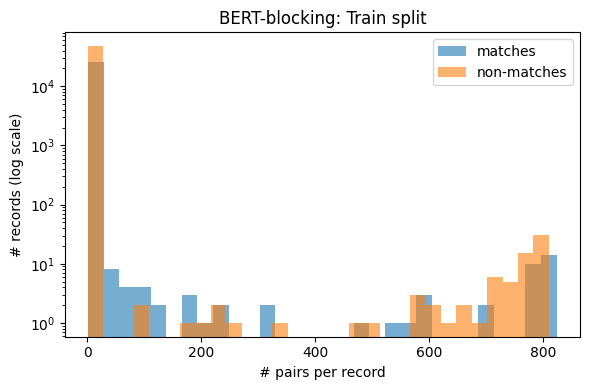


Valid split: 9,999 pairs, 9,992 records appear in at least one pair.
  Matches per used record: mean=0.68, median=0.0, max=115
  Non-matches per used record: mean=1.32, median=1.0, max=120


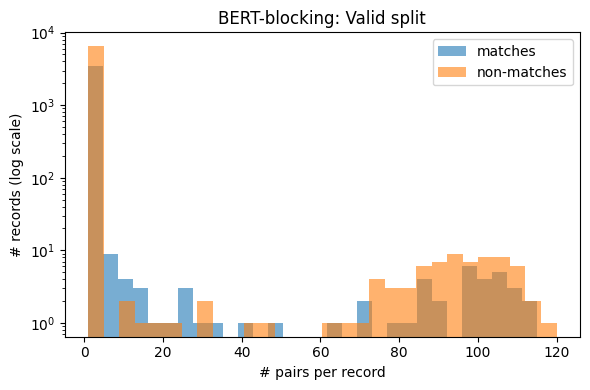


Test split: 10,002 pairs, 9,975 records appear in at least one pair.
  Matches per used record: mean=0.69, median=0.0, max=126
  Non-matches per used record: mean=1.32, median=1.0, max=125


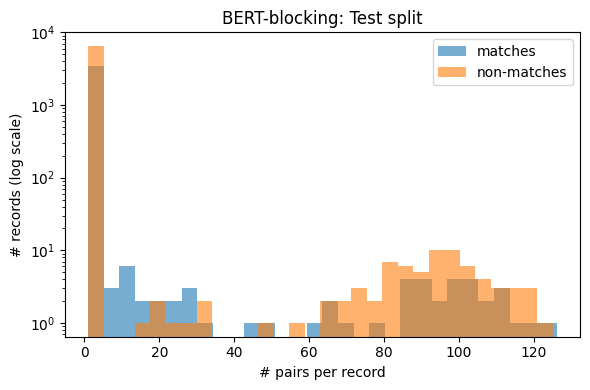

In [64]:
# Analysis A: Distribution of matches / non-matches per record (BERT-blocking dataset)

import numpy as np

# Ensure matplotlib is available (install if needed)
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt

assert 'labeled_pairs' in globals(), "labeled_pairs (BERT-blocking) not found; run the BERT blocking section first."
assert 'train_idx' in globals() and 'valid_idx' in globals() and 'test_idx' in globals(), "train/valid/test indices for BERT-blocking not found."

n_records = len(records_blocking)


def analyze_split_bert(name, split_idx, labeled_pairs):
    """For a given split, compute how many matches and non-matches each record participates in.

    We treat pairs as undirected: both i and j contribute to counts.
    """
    pairs_split = labeled_pairs[split_idx]
    if len(pairs_split) == 0:
        print(f"{name}: no pairs.")
        return

    ij = pairs_split[:, :2].astype(int)
    labels = pairs_split[:, 2].astype(int)

    recs = np.concatenate([ij[:, 0], ij[:, 1]])
    labs = np.concatenate([labels, labels])

    pos_counts = np.bincount(recs, weights=(labs == 1).astype(float), minlength=n_records)
    neg_counts = np.bincount(recs, weights=(labs == 0).astype(float), minlength=n_records)

    # Restrict to records that appear at least once
    mask_used = (pos_counts + neg_counts) > 0
    pos_used = pos_counts[mask_used]
    neg_used = neg_counts[mask_used]

    print(f"\n{name} split: {len(pairs_split):,} pairs, {mask_used.sum():,} records appear in at least one pair.")
    print(f"  Matches per used record: mean={pos_used.mean():.2f}, median={np.median(pos_used):.1f}, max={pos_used.max():.0f}")
    print(f"  Non-matches per used record: mean={neg_used.mean():.2f}, median={np.median(neg_used):.1f}, max={neg_used.max():.0f}")

    # Plot distribution (log-scale y) for visualization
    plt.figure(figsize=(6, 4))
    plt.hist(pos_used[pos_used > 0], bins=30, alpha=0.6, label="matches")
    plt.hist(neg_used[neg_used > 0], bins=30, alpha=0.6, label="non-matches")
    plt.yscale("log")
    plt.xlabel("# pairs per record")
    plt.ylabel("# records (log scale)")
    plt.title(f"BERT-blocking: {name} split")
    plt.legend()
    plt.tight_layout()
    plt.show()


analyze_split_bert("Train", train_idx, labeled_pairs)
analyze_split_bert("Valid", valid_idx, labeled_pairs)
analyze_split_bert("Test", test_idx, labeled_pairs)


Train split (ANN): 159,999 pairs, 137,706 records appear in at least one pair.
  Matches per used record: mean=1.14, median=1.0, max=177
  Non-matches per used record: mean=1.18, median=1.0, max=179


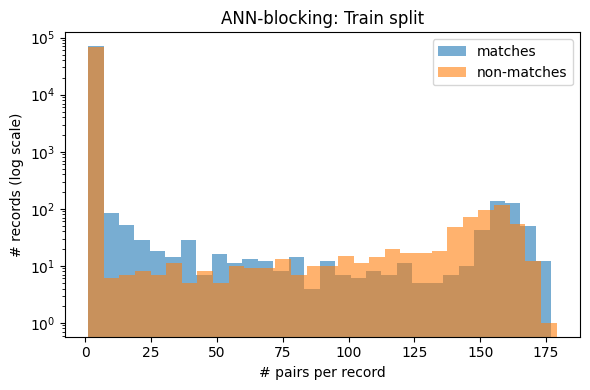


Valid split (ANN): 19,999 pairs, 20,566 records appear in at least one pair.
  Matches per used record: mean=0.96, median=1.0, max=34
  Non-matches per used record: mean=0.99, median=1.0, max=33


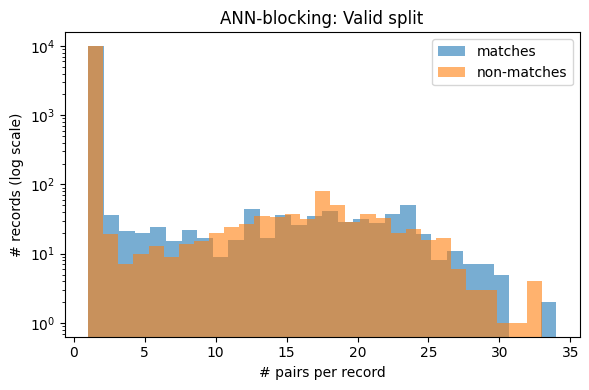


Test split (ANN): 20,002 pairs, 20,571 records appear in at least one pair.
  Matches per used record: mean=0.96, median=1.0, max=34
  Non-matches per used record: mean=0.99, median=1.0, max=32


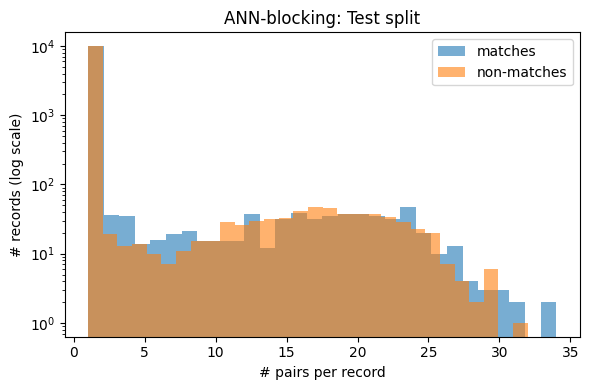

In [65]:
# Analysis B: Distribution of matches / non-matches per record (ANN-blocking dataset)

assert 'labeled_pairs_ann' in globals(), "labeled_pairs_ann (ANN-blocking) not found; run the ANN blocking section first."
assert 'train_idx_ann' in globals() and 'valid_idx_ann' in globals() and 'test_idx_ann' in globals(), "train/valid/test indices for ANN-blocking not found."


def analyze_split_ann(name, split_idx, labeled_pairs_ann):
    pairs_split = labeled_pairs_ann[split_idx]
    if len(pairs_split) == 0:
        print(f"{name} (ANN): no pairs.")
        return

    ij = pairs_split[:, :2].astype(int)
    labels = pairs_split[:, 2].astype(int)

    recs = np.concatenate([ij[:, 0], ij[:, 1]])
    labs = np.concatenate([labels, labels])

    pos_counts = np.bincount(recs, weights=(labs == 1).astype(float), minlength=n_records)
    neg_counts = np.bincount(recs, weights=(labs == 0).astype(float), minlength=n_records)

    mask_used = (pos_counts + neg_counts) > 0
    pos_used = pos_counts[mask_used]
    neg_used = neg_counts[mask_used]

    print(f"\n{name} split (ANN): {len(pairs_split):,} pairs, {mask_used.sum():,} records appear in at least one pair.")
    print(f"  Matches per used record: mean={pos_used.mean():.2f}, median={np.median(pos_used):.1f}, max={pos_used.max():.0f}")
    print(f"  Non-matches per used record: mean={neg_used.mean():.2f}, median={np.median(neg_used):.1f}, max={neg_used.max():.0f}")

    plt.figure(figsize=(6, 4))
    plt.hist(pos_used[pos_used > 0], bins=30, alpha=0.6, label="matches")
    plt.hist(neg_used[neg_used > 0], bins=30, alpha=0.6, label="non-matches")
    plt.yscale("log")
    plt.xlabel("# pairs per record")
    plt.ylabel("# records (log scale)")
    plt.title(f"ANN-blocking: {name} split")
    plt.legend()
    plt.tight_layout()
    plt.show()


analyze_split_ann("Train", train_idx_ann, labeled_pairs_ann)
analyze_split_ann("Valid", valid_idx_ann, labeled_pairs_ann)
analyze_split_ann("Test", test_idx_ann, labeled_pairs_ann)

Reading canonical_int stats from: data/ijf/blocking_sentence_bert/pro_supplier_with_clean_and_canonical_trimmed.csv
Total canonical_int values (including 0): 157804
Min count per canonical_int: 1
Max count per canonical_int: 17552
Mean count per canonical_int: 8.80
Median count per canonical_int: 2.0

Top 20 canonical_ints by count:
canonical_int=    13 | count= 17552 | example_clean_name=CANADIAN CORPS COMMISSIONAIRES
canonical_int=    26 | count= 12643 | example_clean_name=EXCELHR
canonical_int=     6 | count=  8032 | example_clean_name=MCKESSON CANADA
canonical_int=    17 | count=  7365 | example_clean_name=VERITAAQ TECHNOLOGY HOUSE
canonical_int=    14 | count=  6397 | example_clean_name=CALIAN
canonical_int=   281 | count=  6279 | example_clean_name=FISHER SCIENTIFIC
canonical_int=    19 | count=  6172 | example_clean_name=IMPERIAL OIL
canonical_int=   310 | count=  6051 | example_clean_name=SIMEX DEFENCE
canonical_int=     5 | count=  5970 | example_clean_name=NORTHERN MICRO
cano

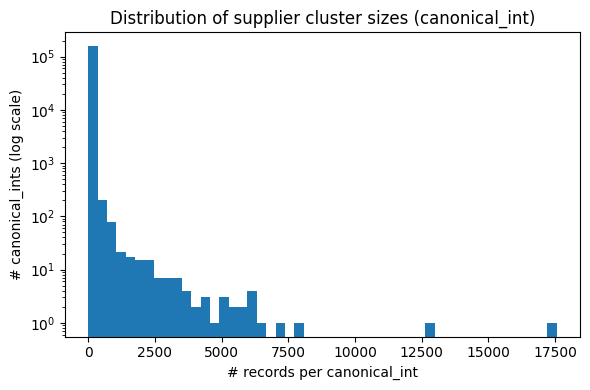

In [66]:
# Analysis C: Canonical_int statistics from CSV (count and example clean_supplier_name)

import csv
import re
from collections import defaultdict

# Reuse CSV_PATH_BLOCKING from the earlier BERT-blocking section if available
try:
    csv_path = CSV_PATH_BLOCKING
except NameError:
    csv_path = os.path.join(DITTO_DIR, "data/ijf/blocking_sentence_bert/pro_supplier_with_clean_and_canonical_trimmed.csv")

print(f"Reading canonical_int stats from: {csv_path}")

canon_counts = defaultdict(int)
canon_example_name = {}

pattern_name = re.compile(r"COL\s+clean_supplier_name\s+VAL\s+(.*?)(?=\s+COL\s+|\s*$)")

for (idx, rec_str), cid in zip(records_blocking, canonical_ints):
    cid = int(cid)
    canon_counts[cid] += 1
    if cid not in canon_example_name:
        m = pattern_name.search(rec_str)
        name = m.group(1).strip() if m else ""
        canon_example_name[cid] = name

n_canon = len(canon_counts)
print(f"Total canonical_int values (including 0): {n_canon}")

# Basic distribution stats
counts_arr = np.array(list(canon_counts.values()))
print(f"Min count per canonical_int: {counts_arr.min()}")
print(f"Max count per canonical_int: {counts_arr.max()}")
print(f"Mean count per canonical_int: {counts_arr.mean():.2f}")
print(f"Median count per canonical_int: {np.median(counts_arr):.1f}")

# Show top 20 canonical_ints by size
print("\nTop 20 canonical_ints by count:")
for cid, cnt in sorted(canon_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
    name = canon_example_name.get(cid, "")
    print(f"canonical_int={cid:6d} | count={cnt:6d} | example_clean_name={name}")

# Optional: histogram of canonical_int sizes
plt.figure(figsize=(6, 4))
plt.hist(counts_arr, bins=50)
plt.yscale("log")
plt.xlabel("# records per canonical_int")
plt.ylabel("# canonical_ints (log scale)")
plt.title("Distribution of supplier cluster sizes (canonical_int)")
plt.tight_layout()
plt.show()